# Название проекта: Маркетинг

## Цель проекта:
Используя имеющиеся данные о покупках пользователей и коммуникационные данные с пользователями, постоить модель классификации пользователей. Для 
предсказания, какие из пользователей совершат покупку.
## Состав данных:
**Основные**
* apparel-messages.csv
* apparel-purchases.csv
* apparel-target_binary.csv

**Вспомогательные**
* full_campaign_daily_event.csv
* full_campaign_daily_event_channel.csv
## Обратить внимание:
*  В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей– это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`.
*  На основании имеющихся данных необходимо создать дополнительные признаки, для улучшения качетва модели.

## План работы над проектом:
* `Загрузка данных`. Необходимо загрузить 5 датафреймов, получить первоначальное представление о данных.
* `Изучение признаков`. Изучим состав данных каждого из основных датафреймов. Определим нужна ли импутиация.
* ....

# Настройка окружения

In [4]:
# установка модулей
!pip install phik -q
!pip install scikit-learn==1.6.1 -q
!pip install shap -q
!pip install matplotlib==3.9.2 -q
!pip install catboost -q

In [5]:
# загрузка модулей
import ast
import os
import phik
import random
import shap

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    make_scorer
)

# Определение констант

In [7]:
# определяем константы
DATAFRAME_PATH = 'datasets/'
TEST_SIZE = .25
RANDOM_STATE = 165
# определим целевой признак
TARGET = 'target'
# какую долю минорный класс будет составлять от мажорного
# при оверсэмплинге
MINOR_COEF = .2
# во сколько раз сэмпл с мажорным классом будет больше минорного
# при андерсэмплинге
MAJOR_COEF = 9 

In [8]:
# отображение чисел с плавающей точкой в формате .4f
pd.set_option('display.float_format', '{:.4f}'.format)

# Загрузка данных.

In [10]:
# функция загрузки данных в датафрейм
def df_load(file_name, *arg):
    if not os.path.exists(DATAFRAME_PATH + file_name):
        raise ValueError(f'Файл {file_name} не найден.')
    try:
        df = pd.read_csv(DATAFRAME_PATH + file_name, sep=arg[0], decimal=arg[1])
        print(f'Данные {file_name} успешно загружены')
    except Exception as err:
        raise ValueError(f'Ошибка загрузки данных из файла {file_name}: {err}')
    print(f'Размерность датафрейма: {df.shape}\n'
          'Общая информация о датафрейме:')
    print(df.info())
    return(df)

In [11]:
df_messages = df_load('apparel-messages.csv', ',', '.')

Данные apparel-messages.csv успешно загружены
Размерность датафрейма: (12739798, 7)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None


In [12]:
df_messages_shape = df_messages.shape

In [13]:
df_purchases = df_load('apparel-purchases.csv', ',', '.')

Данные apparel-purchases.csv успешно загружены
Размерность датафрейма: (202208, 6)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
None


In [14]:
df_purchases_shape = df_purchases.shape

In [15]:
df_target = df_load('apparel-target_binary.csv', ',', '.')

Данные apparel-target_binary.csv успешно загружены
Размерность датафрейма: (49849, 2)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


In [16]:
df_target_shape = df_target.shape

In [17]:
df_event = df_load('full_campaign_daily_event.csv', ',', '.')

Данные full_campaign_daily_event.csv успешно загружены
Размерность датафрейма: (131072, 24)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_har

In [18]:
df_channel = df_load('full_campaign_daily_event_channel.csv', ',', '.')

Данные full_campaign_daily_event_channel.csv успешно загружены
Размерность датафрейма: (131072, 36)
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_uns

In [19]:
df_messages.sample(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
1979055,7180,1515915625468069361,1515915625468069361-7180-634d2f8014e67,send,email,2022-10-17,2022-10-17 11:57:50
2829774,8252,1515915625559754137,1515915625559754137-8252-6386fd869e5fa,open,email,2022-11-30,2022-11-30 14:09:35
2367384,7659,1515915625541979706,1515915625541979706-7659-6368e5694da85,open,email,2022-11-10,2022-11-10 14:32:35
1076149,5858,1515915625583134286,1515915625583134286-5858-62ed226d2da30,send,mobile_push,2022-08-05,2022-08-05 14:10:54
12440771,14618,1515915625902058454,1515915625902058454-14618-65c4ce7a90414,send,mobile_push,2024-02-08,2024-02-08 12:56:52
12253114,14576,1515915625502480713,1515915625502480713-14576-65badf6d27a01,open,mobile_push,2024-02-01,2024-02-01 00:03:17
3763174,9601,1515915625629298840,1515915625629298840-9601-63d0ece7f0539,send,email,2023-01-25,2023-01-25 10:10:05
11284591,14426,1515915625558818584,1515915625558818584-14426-65992efad12e2,send,mobile_push,2024-01-06,2024-01-06 13:20:19
11471252,14456,1515915625559844711,1515915625559844711-14456-659fb03e5fd4c,open,mobile_push,2024-01-11,2024-01-11 10:45:46
11654742,14499,1515915625551085377,1515915625551085377-14499-65a8cccf37f0a,open,mobile_push,2024-01-18,2024-01-18 07:06:59


## Выводы по разделу:
* Загрузи данные в 5 датафреймов без ошибок. Вывели общую инфомацию по датафреймам и несколь строк из датафрейма `df_messages`.
* При первом взгляде в датафреймах `df_purchases`, `df_target`, `df_event`, `df_channel` пропусков не зафиксировано.
* В датафрейме `df_messages` с пропусками пока не ясно, но точно есть несовпадение типов признаков и значений `date`, `created_at`.
* Так же в датафрейме `df_channel` есть несовпадение типа признака `date`.
* Зафиксирована начальная размерность датафреймов.

# TEst

In [22]:
df_messages[df_messages['client_id'] == 1515915625583487888]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at


In [23]:
df_purchases[df_purchases['client_id'] == 1515915625557043414]

,client_id,quantity,price,category_ids,date,message_id
7626,1515915625557043414,1,399.0000,"['4', '28', '244', '432']",2022-06-02,1515915625489896401-4679-6297220cb21c3
7627,1515915625557043414,1,599.0000,"['4', '28', '57', '431']",2022-06-02,1515915625489896401-4679-6297220cb21c3
7628,1515915625557043414,1,599.0000,"['4', '28', '244', '432']",2022-06-02,1515915625489896401-4679-6297220cb21c3
156183,1515915625557043414,1,280.0000,"['4', '28', '244', '432']",2023-07-10,1515915625489896401-13471-64abf232cf7dc
156184,1515915625557043414,1,280.0000,"['4', '28', '244', '432']",2023-07-10,1515915625489896401-13471-64abf232cf7dc
156185,1515915625557043414,1,399.0000,"['4', '28', '244', '432']",2023-07-10,1515915625489896401-13471-64abf232cf7dc
156186,1515915625557043414,1,399.0000,"['4', '28', '244', '432']",2023-07-10,1515915625489896401-13471-64abf232cf7dc
156187,1515915625557043414,1,280.0000,"['4', '28', '244', '432']",2023-07-10,1515915625489896401-13471-64abf232cf7dc
156188,1515915625557043414,1,3.0000,"['4', '28', '244', '432']",2023-07-10,1515915625489896401-13471-64abf232cf7dc


In [24]:
df_test = pd.merge(df_target, df_purchases, how="left", on='client_id')
df_test.shape

(202208, 7)

# Изучение признаков.

Посмотрим на состав признаков каждого из основных датафреймов (`df_messages`, `df_purchases`, `df_target`)

In [27]:
# функция отображения информации о категориальном признаке
# количестве символов в значении
def str_feature_info(df, feature):
    lengths = df[feature].apply(lambda x: len(x) if pd.notna(x) else np.nan)
    print(lengths.describe())

In [28]:
# функция построения диаграммы распределения признака
def custom_bar(df, feature):
    sns.set(
        context='notebook',
        style='darkgrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=False,
        rc=None
    )
    data = df[feature].value_counts().reset_index()
    data.columns=['value', 'counts']
    sns.barplot(
        x='value',
        y='counts',
        data=data
    )
    plt.title(f'Гистограмма распределения признака {feature}')
    plt.xticks(rotation=0)
    plt.xlabel('Значения')
    plt.ylabel('Частота')
    plt.show()

In [29]:
# выводит тип признака с оформлением
def feature_type(df, feature):
    print(f'Тип признака {feature} - {df[feature].dtype}')

In [30]:
# функция поиска пропусков в датафреймах
def nan_check(*arg):
    for i, item in enumerate(arg):
        check = item.isna().sum().sum()
        print(f'В датафрейме №{i+1} найдено {check} пропусков')
        percent_missing = round(item.isnull().sum() * 100 / len(item), 3)
        if check:
            print(pd.concat([item.isna().sum(), percent_missing], keys=['Количество', 'Процент'], axis=1), '\n')

## df_messages

Признаки:
* `bulk_campaign_id` - идентификатор рассылки
* `client_id` - идентификатор клиента
* `message_id` - идентификатор сообщения
* `event` - действие с сообщением (отправлено, открыто, покупка…)
* `channel` - канал рассылки
* `date` - дата действия
* `created_at` - дата-время полностью 

### bulk_campaign_id

In [34]:
feature_type(df_messages, 'bulk_campaign_id')

Тип признака bulk_campaign_id - int64


In [35]:
print(f'Количество уникальных значений признака - {len(df_messages["bulk_campaign_id"].unique())}')

Количество уникальных значений признака - 2709


In [36]:
df_messages['bulk_campaign_id'].describe()

count   12739798.0000
mean       11604.5876
std         3259.2111
min          548.0000
25%         8746.0000
50%        13516.0000
75%        14158.0000
max        14657.0000
Name: bulk_campaign_id, dtype: float64

In [37]:
df_messages['bulk_campaign_id'].value_counts()

bulk_campaign_id
14272    104479
14276     63826
4679      50621
11760     45985
14081     44884
          ...  
1080          1
548           1
4478          1
754           1
4899          1
Name: count, Length: 2709, dtype: int64

* Всего было `2709` рекламных компаний.
* Аномально больших или маленьких значений нет, ни в значении признака ни в его распределении (нулевых значений нет).

### client_id

In [40]:
feature_type(df_messages, 'client_id')

Тип признака client_id - int64


In [41]:
print(f'Количество уникальных значений признака - {len(df_messages["client_id"].unique())}')

Количество уникальных значений признака - 53329


In [42]:
df_messages['client_id'].describe()

count              12739798.0000
mean    1515915625574831616.0000
std               326551798.1577
min     1515915625468060928.0000
25%     1515915625489149440.0000
50%     1515915625503432192.0000
75%     1515915625591286272.0000
max     1515915626010288640.0000
Name: client_id, dtype: float64

In [43]:
df_messages['client_id'].value_counts()

client_id
1515915625516327994    3100
1515915625625548006    3090
1515915625804998560    2764
1515915625489071904    1845
1515915625489095763    1454
                       ... 
1515915625550299889       1
1515915625977549113       1
1515915625840706531       1
1515915625586111659       1
1515915625577289455       1
Name: count, Length: 53329, dtype: int64

* Всего уникальных пользователей в рассылках `53329`.
* Все ID имеют одно количество символов в значении.
* В распределении признака аномально больших значений нет.

### message_id

In [46]:
feature_type(df_messages, 'message_id')

Тип признака message_id - object


In [47]:
df_messages['message_id'].sample(3)

5232265    1515915625487459752-12838-646efa62d23a8
3779406     1515915625600271211-9615-63d12c44d2696
9353703    1515915625581452108-14118-6554b050e8dd3
Name: message_id, dtype: object

In [48]:
print(f'Количество уникальных значений признака - {len(df_messages["message_id"].unique())}')

Количество уникальных значений признака - 9061667


In [49]:
str_feature_info(df_messages, 'message_id')

count   12739798.0000
mean          38.6882
std            0.4632
min           37.0000
25%           38.0000
50%           39.0000
75%           39.0000
max           39.0000
Name: message_id, dtype: float64


* Уникальных значений сообщений `9_061_667`
* ID сообщения судя по всему представляет собой комбинацию из ID пользователя, ID рассылки и еще какого-то идентификатора (возможно ID самой сообщения).
* Все идентификаторы содержат `37-39` символов.
* Аномальных значений нет.

### event

In [52]:
feature_type(df_messages, 'event')

Тип признака event - object


In [53]:
df_messages['event'].sample(3)

8983000     send
12137343    send
8621173     open
Name: event, dtype: object

In [54]:
print(f'Количество уникальных значений признака - {len(df_messages["event"].unique())}')

Количество уникальных значений признака - 11


In [55]:
df_messages['event'].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

* Уникальных значений признака `11`.
* Аномальных значений нет.

### channel

In [58]:
feature_type(df_messages, 'channel')

Тип признака channel - object


In [59]:
df_messages['channel'].sample(3)

5681399     mobile_push
11752027    mobile_push
5462049           email
Name: channel, dtype: object

In [60]:
print(f'Количество уникальных значений признака - {len(df_messages["channel"].unique())}')

Количество уникальных значений признака - 2


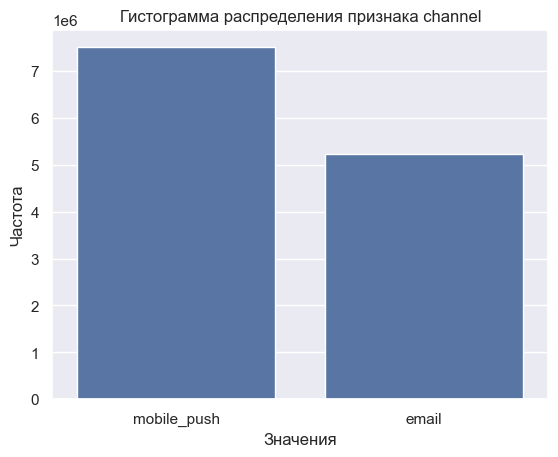

In [61]:
custom_bar(df_messages, 'channel')

* Уникальных значений `2`.
* Распределение признака примерно `60% - mobile_push` и `40% - email`.
* Аномальных значений нет.

### date

In [64]:
feature_type(df_messages, 'date')

Тип признака date - object


In [65]:
df_messages['date'].sample(3)

2060638     2022-10-21
7059594     2023-08-18
11537369    2024-01-13
Name: date, dtype: object

In [66]:
str_feature_info(df_messages, 'date')

count   12739798.0000
mean          10.0000
std            0.0000
min           10.0000
25%           10.0000
50%           10.0000
75%           10.0000
max           10.0000
Name: date, dtype: float64


In [67]:
df_messages['date'] = pd.to_datetime(df_messages['date'])

In [68]:
feature_type(df_messages, 'date')

Тип признака date - datetime64[ns]


* Несовпадение значения с типом признака (нужен datetime).
* Все значения имеют длину `10` символов.
* Аномальных значений нет.
* Преобразован в datetime.

### created_at

In [71]:
feature_type(df_messages, 'created_at')

Тип признака created_at - object


In [72]:
df_messages['created_at'].sample(3)

10459107    2023-12-16 14:19:33
4244975     2023-03-03 13:23:46
8609708     2023-10-19 06:06:02
Name: created_at, dtype: object

In [73]:
str_feature_info(df_messages, 'created_at')

count   12739798.0000
mean          19.0000
std            0.0000
min           19.0000
25%           19.0000
50%           19.0000
75%           19.0000
max           19.0000
Name: created_at, dtype: float64


In [74]:
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
feature_type(df_messages, 'created_at')

Тип признака created_at - datetime64[ns]


* Несовпадение значения с типом признака (нужен datetime).
* Все значения имеют длину `19` символов.
* Аномальных значений нет.
* Признак будет полезен для поиска явных дублей.
* Преобразован в datetime.

### Пропуски.

In [77]:
nan_check(df_messages)

В датафрейме №1 найдено 0 пропусков


### Дубликаты.

In [79]:
print(f'Количество явных дублей в датафрейме df_messages - {df_messages.duplicated().sum()}')

Количество явных дублей в датафрейме df_messages - 48610


## df_purchases

Признаки:
* `client_id` - идентификатор клиента (**int**)
* `quantity` - количество единиц товара (**int**)
* `price` - цена товара (**float**)
* `category_ids` - идентификаторы категорий (**object**)
* `date` - дата покупки (**object**)
* `message_id` - идентификатор сообщения из рассылки (**object**)

### client_id

In [83]:
print(f'Количество уникальных значений признака - {len(df_purchases["client_id"].unique())}')

Количество уникальных значений признака - 49849


In [84]:
df_purchases['client_id'].describe()

count                202208.0000
mean    1515915625596210944.0000
std               145951436.3692
min     1515915625468060928.0000
25%     1515915625490081280.0000
50%     1515915625557177088.0000
75%     1515915625624391936.0000
max     1515915626010443520.0000
Name: client_id, dtype: float64

In [85]:
df_purchases['client_id'].value_counts()

client_id
1515915625853312319    346
1515915625624308268    218
1515915625607113301    210
1515915625500232103    131
1515915625470860261    131
                      ... 
1515915625559962326      1
1515915625559941251      1
1515915625468133517      1
1515915625559866916      1
1515915626010443624      1
Name: count, Length: 49849, dtype: int64

* Уникальных значений `49849`.
* Все ID имеют одинаковое количество символов.
* Аномальных значений нет.

### quantity

In [88]:
print(f'Количество уникальных значений признака - {len(df_purchases["quantity"].unique())}')

Количество уникальных значений признака - 16


In [89]:
df_purchases['quantity'].describe()

count   202208.0000
mean         1.0065
std          0.1844
min          1.0000
25%          1.0000
50%          1.0000
75%          1.0000
max         30.0000
Name: quantity, dtype: float64

In [90]:
df_purchases['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

* Уникальных значений признака `16`.
* Признак имеет распределение от `1 до 30`.
* Аномльно высоких и нулевых значений нет.

### price

In [93]:
df_purchases['price'].describe()

count   202208.0000
mean      1193.3015
std       1342.2527
min          1.0000
25%        352.0000
50%        987.0000
75%       1699.0000
max      85499.0000
Name: price, dtype: float64

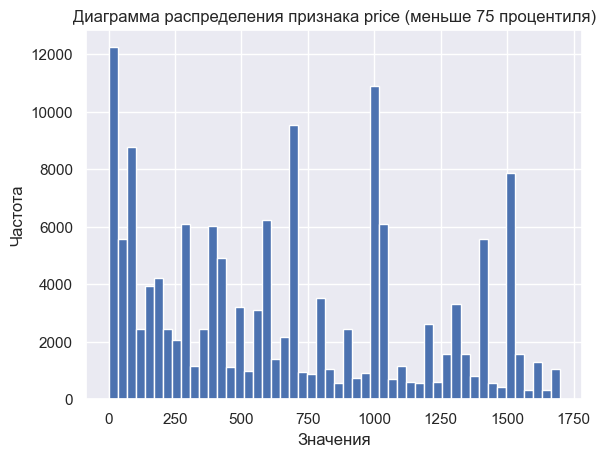

In [94]:
# посмотрим распределение признака ниже 75-го процентиля
plt.hist(df_purchases[df_purchases['price'] < df_purchases['price'].quantile(.75)]['price'], bins=50)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Диаграмма распределения признака price (меньше 75 процентиля)')
plt.show()

* Нулевых значенйи цены нет.
* Высокие значения цены лежат выше 75-го процентиля.
* Нет нормального распределения признака.
* Аномально высоких значений нет.

### category_ids

In [97]:
df_purchases['category_ids'].sample(3)

3811            ['2', '18', '274', '450']
115187          ['4', '27', '138', '468']
87677     ['5562', '5630', '5687', '558']
Name: category_ids, dtype: object

In [98]:
print(f'Количество уникальных значений признака - {len(df_purchases["category_ids"].unique())}')

Количество уникальных значений признака - 933


In [99]:
str_feature_info(df_purchases, 'category_ids')

count   202208.0000
mean        25.9967
std          5.3042
min          2.0000
25%         25.0000
50%         25.0000
75%         31.0000
max         32.0000
Name: category_ids, dtype: float64


* Уникальных комбинаций категорий `933`.
* Минимальная длина признака 2, с учетом квадратных скобок это значит, что признак не содержит никаких категорий. Вероятно на момент выгрузки таких категорий уже не существовало. Такие значения можно приравнять к пропускам.
* Из задания известно, что вложенность категорий может меняться. Первоначальное предложение заменить признак на два новых: Основная категория и последняя. Тогда незначительные изменения дерева категорий не повлияют на значения этих признаков.

### date

In [102]:
df_purchases['date'].sample(3)

119365    2023-05-06
128882    2023-06-06
80069     2022-12-29
Name: date, dtype: object

In [103]:
str_feature_info(df_purchases, 'date')

count   202208.0000
mean        10.0000
std          0.0000
min         10.0000
25%         10.0000
50%         10.0000
75%         10.0000
max         10.0000
Name: date, dtype: float64


In [104]:
df_purchases['date'] = pd.to_datetime(df_purchases['date'])

In [105]:
feature_type(df_purchases, 'date')

Тип признака date - datetime64[ns]


* Несовпадение значения с типом признака (нужен datetime).
* Несовпадение устранено.
* Все значения имеют длину `10` символов.
* Аномальных значений нет.

### message_id

In [108]:
df_purchases['message_id'].sample(3)

191439    1515915625609719907-14421-6593b4583d30a
100790    1515915625468172460-11760-64367482668d2
147180    1515915625488706454-13415-649c2f752cf04
Name: message_id, dtype: object

In [109]:
print(f'Количество уникальных значений признака - {len(df_purchases["message_id"].unique())}')

Количество уникальных значений признака - 50204


In [110]:
str_feature_info(df_purchases, 'message_id')

count   202208.0000
mean        38.5759
std          0.4944
min         37.0000
25%         38.0000
50%         39.0000
75%         39.0000
max         39.0000
Name: message_id, dtype: float64


* Уникальных значений сообщений `50_204`
* ID сообщения судя по всему представляет собой комбинацию из ID пользователя, ID рассылки и еще какого-то идентификатора (возможно ID самой сообщения).
* Все идентификаторы содержат `37-39` символов.
* Аномальных значений нет.

### Пропуски

In [113]:
nan_check(df_purchases)

В датафрейме №1 найдено 0 пропусков


### Дубликаты.

In [115]:
print(f'Количество явных дублей в датафрейме df_purchases - {df_purchases.duplicated().sum()}')

Количество явных дублей в датафрейме df_purchases - 73020


## df_target

Признаки:
* `client_id` - идентификатор клиента (**int**)
* `target` - клиент совершил покупку в целевом период (**int**)

### client_id

In [119]:
df_target['client_id'].describe()

count                 49849.0000
mean    1515915625598796032.0000
std               148794665.0851
min     1515915625468060928.0000
25%     1515915625489972736.0000
50%     1515915625556614912.0000
75%     1515915625633408768.0000
max     1515915626010443520.0000
Name: client_id, dtype: float64

In [120]:
print(f'Количество дубликатов признака client_id - {df_target["client_id"].duplicated().sum()}')

Количество дубликатов признака client_id - 0


* Уникальных значений `49849`.
* Все ID имеют одинаковое количество символов.
* Аномальных значений нет.

### target

In [123]:
df_target['target'].describe()

count   49849.0000
mean        0.0193
std         0.1375
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         1.0000
Name: target, dtype: float64

In [124]:
df_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

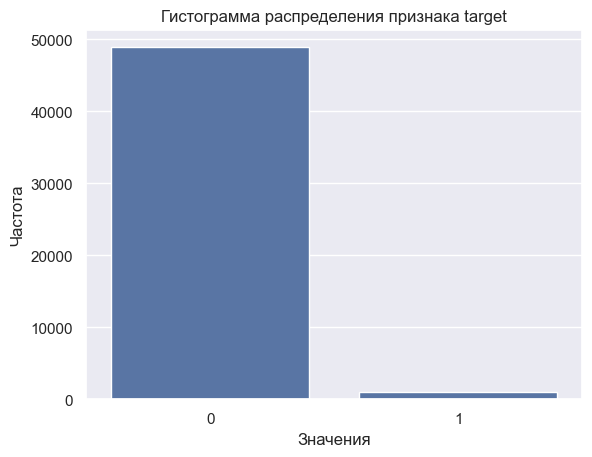

In [125]:
custom_bar(df_target, 'target')

In [126]:
round((df_target.groupby(by='target')['target'].count() / len(df_target))*100, 2)

target
0   98.0700
1    1.9300
Name: target, dtype: float64

* Признак имеет 2 уникальных значения
* Наблюдается сильный дисбаланс в строну нулевого значения `2% - [1]`, `98% - [0]`.

### Пропуски.

In [129]:
nan_check(df_target)

В датафрейме №1 найдено 0 пропусков


### Дубликаты.

In [131]:
print(f'Количество явных дублей в датафрейме df_target - {df_target.duplicated().sum()}')

Количество явных дублей в датафрейме df_target - 0


## Выводы по разделу:
* Изучены все признаки основных датафреймов.
* Потверждены несоответствия типов признаков `date` и `created_at` в датафреймах `df_messages` и `date` в `df_purchases`.
* Преобразованы в типы datetime.
* Количество уникальных пользователей в датафрейме `df_messages` (53329) не соответсвует количеству в датафреймах `df_purchases` и `df_target` (49849).
* В значениях признака `category_ids` наблюдается неконсистентность. Требуется импутация.
* Количество явных дублей:
  * `df_messages` - 48610
  * `df_purchases` - 73020
  * `df_target` - 0
* Пропусков в датафреймах нет.
* В остальных признаках аномалий не выявлено.

# Удаление дубликатов.

## df_messages

In [135]:
# удаление дубликатов
df_messages = df_messages.drop_duplicates()

In [136]:
print(f'Потеря данных составила {1 - df_messages.shape[0] / df_messages_shape[0]:.2%}')

Потеря данных составила 0.38%


In [137]:
# сохраним новую размерность датафрейма
df_messages_shape = df_messages.shape

## df_purchases

В этом случае при удалении дубликатов ожидаемая потеря данных составит более трети. Это достаточно много.

In [140]:
print(f'Ожидаемая потеря данных составит {1 - df_purchases.drop_duplicates().shape[0] / df_purchases_shape[0]:.2%}')

Ожидаемая потеря данных составит 36.11%


Есть конечно вероятность, что пользователи совершили повторную покупку в тот же день, в том же количестве и с той же ценой. Но без дополнительной информации это установить не получится.

In [142]:
print(f'Уникальных пользователей имеющих дублированные покупки: '
      f'{(
          1 - len(df_purchases[df_purchases.duplicated(keep=False)]['client_id'].unique()) / len(df_purchases['client_id'].unique())
      ):.2%}')

Уникальных пользователей имеющих дублированные покупки: 45.42%


In [143]:
print(f"Дней в которые было замечено дублирование покупок: "
      f"{len(df_purchases[df_purchases.duplicated()]['date'].unique())}")

Дней в которые было замечено дублирование покупок: 630


In [144]:
df_purchases[df_purchases.duplicated()]['date'].value_counts().head(10)

date
2022-11-11    2462
2023-04-28    1488
2023-06-10    1480
2022-11-15    1281
2022-12-22    1146
2022-12-21    1120
2022-11-12    1016
2022-11-13    1003
2022-12-16     985
2023-06-11     882
Name: count, dtype: int64

* Практически у половины пользователей было замечено дублирование записей о покупках. Если каждый второй делает повторную покупку в тот же день, то это либо члены клуба любителей повторных покупок, либо все таки ошибка в данных.
* По дням какой-то закономерности нет, но больше всего дублей в `2022 - 2023` годах.
* Учитывая количество дней в которые проявились дубли, такое происходит почти каждый день. Нужно дать совет заказчику проверись систему логирования данных.
* Будем считать это аномалией и удалим дублирующиеся строки.

In [146]:
# удаление дубликатов
df_purchases = df_purchases.drop_duplicates()

In [147]:
print(f'Потеря данных составила {1 - df_purchases.shape[0] / df_purchases_shape[0]:.2%}')

Потеря данных составила 36.11%


In [148]:
# сохраним новую размерность датафрейма
df_purchases_shape = df_purchases.shape

## Вывод по разделу:
* В датафрейме `df_messages` удалены явные дубли, потеря данных `0.38%`.
* В датафрейме `df_purchases` удалены явные дубли, потеря данных `36.11%`.

# Импутация данных.

Повторно осмотрим датафреймы на предмет пропусков.

In [152]:
nan_check(df_messages, df_purchases, df_target)

В датафрейме №1 найдено 0 пропусков
В датафрейме №2 найдено 0 пропусков
В датафрейме №3 найдено 0 пропусков


У нас была проблема с признаком `category_ids` в датафрейме `df_purchases`. Признак имеет строковый тип и состоит из спика идентификаторов категорий. Сначала преобразуем строку в список, затем создадим плоский список из категорий и проверим на количество пропусков.

In [154]:
print(f'Количество значений признака category_ids состоящих из пустых скобок: '
      f'{df_purchases.loc[(df_purchases['category_ids'].apply(lambda x: len(x)) == 2) , 'category_ids'].count()}')

Количество значений признака category_ids состоящих из пустых скобок: 2738


Возможно пропуски есть не только одиночные, но и в структуре дерева категорий.

In [156]:
# преобразуем строковое значение признака в список
df_purchases['category_ids'] = df_purchases['category_ids'].apply(ast.literal_eval)

In [157]:
# создадим плоский список значений признака
flat = df_purchases['category_ids'].explode()

In [158]:
print(f'Пропусков среди значений признака - {flat.isna().sum()}')

Пропусков среди значений признака - 3360


Теперь пропуски нужно чем то заполнить. Заполним заглушкой, вида `нет категории`, но т.к. у нас список цифровых идентификаторов, то заполним цифровой заглушкой несуществующего идентификатора.

In [160]:
# отсортируем значения признака category_ids
flat.sort_values()

29809        1
22938        1
5990         1
108856      10
137085    1001
          ... 
201914     NaN
201964     NaN
201989     NaN
202068     NaN
202144     NaN
Name: category_ids, Length: 506281, dtype: object

Нумерация категорий идет с 1, чтобы случайно не выбрать в качестве заглушки существующую категорию или которая может появиться в будующем, возьмем **-1**.

In [162]:
# функция заменяет Nan и None на -1 в списке
# если список пустой то тоже -1
def nan_fill(x):
    res = [-1 if pd.isna(i) else i for i in x]
    return res if len(res) > 0 else [-1]

In [163]:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(nan_fill)

Повторно проведем процедуру определения количества пропусков в признаке.

In [165]:
print(f'Пропусков среди значений признака - {df_purchases['category_ids'].explode().isna().sum()}')

Пропусков среди значений признака - 0


## Выводы по разделу:
* Убедились что признак содержит неконсистентные значения.
* Преобразовали строковый тип значения признака в список.
* Выявлено `3360` пропусков.
* Проведена импутация пропусков и пустых значений заглушкой.
* В качестве заглушки определено значение `-1`.
* Пропусков больше нет.

# Создание новых признаков.

## df_messages

**Возможные варианты**
* Количество рассылок на пользователя `bulk_by_user`. +
* Количество сообщений на пользователя `message_by_user`. +
* Самое частое действие или Количество каждого действия `send` и т.д. + 
* Самый частый канал или Количество сообщений на каждый канал `email` и `mobile_push`. +
* Разница между последним и первым эвентом, можно предположить сколько времени клиент зарегестрирован `duration`. +
* Отдельно вынесем дату первую рассылки, потом можно вычислить разницу между последней покупкой и создать признак `длительность активности`. +
* Частота сообщений (количество сообщений в условную единицу времени, например в квартал) `messages_per_quarter`. +

In [170]:
# убедимся что каждое сообщение адресовано только одному пользователю
df_messages.groupby('message_id')['client_id'].nunique().sort_values(ascending=False).head(5)

message_id
1515915625468060902-10022-63e5ededd911f    1
1515915625564758192-13340-64859b65b8299    1
1515915625564758192-12911-6471c27f783c1    1
1515915625564758192-13069-6479c8e439f9c    1
1515915625564758192-13228-648075a1ae60c    1
Name: client_id, dtype: int64

In [171]:
# количество рассылочных компаний в которых фигурировал пользователь
df_messages['bulk_by_user'] = df_messages.groupby('client_id')['bulk_campaign_id'].transform('nunique')

In [172]:
# количество рассылок в которых фигурировал пользователь
df_messages['messages_by_client'] = df_messages.groupby('client_id')['message_id'].transform('nunique')

In [173]:
# создаем признаки с названием канала коммуникации и количеством сообщений по нему
channel_counts = df_messages.drop_duplicates('message_id').groupby(
    ['client_id', 'channel']
)['channel'].count().unstack(fill_value=0)
df_messages = df_messages.join(channel_counts, on='client_id')

In [174]:
# посчитаем количество каждого значения event для пользователя
# и вынесем в отдельные признаки каждый event
event_counts = df_messages.groupby(
    ['client_id', 'event']
)['event'].count().unstack(fill_value=0)
df_messages = df_messages.join(event_counts, on='client_id')

In [175]:
# добавим признак дата первого сообщения
df_messages['first_message_date'] = df_messages.groupby('client_id')['date'].transform('min')

In [176]:
# посчитаем для каждого пользователя дату первого и последнего сообщения,
# разницу в днях запишем в признак `duration`, сколько клиент является зарегестрированным 
# пользователем
result = df_messages.groupby('client_id').agg(
    first_event=('date', 'min'),    
    last_event=('date', 'max')      
)
result['duration'] = (result['last_event']-result['first_event']).dt.days
df_messages = df_messages.join(result['duration'], on='client_id' )

In [177]:
# для каждой даты сообщения вычисли квартал
df_messages['quarter'] = df_messages['date'].dt.quarter

In [178]:
# для каждого пользователя посчитаем количество уникальных сообщений в квартал 
# создадим признак messages_per_quarter
df_messages['messages_per_quarter'] = df_messages.groupby(['client_id', 'quarter'])['message_id'].transform('nunique')

In [179]:
print('Признаки датафрейма после добавления новых:')
for feature in df_messages.columns.tolist():
    print(f'- {feature}')

Признаки датафрейма после добавления новых:
- bulk_campaign_id
- client_id
- message_id
- event
- channel
- date
- created_at
- bulk_by_user
- messages_by_client
- email
- mobile_push
- click
- close
- complain
- hard_bounce
- hbq_spam
- open
- purchase
- send
- soft_bounce
- subscribe
- unsubscribe
- first_message_date
- duration
- quarter
- messages_per_quarter


Отберем признаки которые нам не интресены:
* `complain` - жалоба
* `hard_bounce` - неактивные адрес
* `soft_bounce` - ящик не может принять письмо
* `subscribe` - подписка
* `unsubscribe` - отписка
* `hbq_spam` - попало в спам
* `close` - закрытие
* `quarter` - номер квартала, использовался для расчета частоты отправки
* `event` - событие, мы конвертировали в признаки значений события
* `channel` - канал, мы конвертировали в признаки `email` и `mobile_phone`
* `message_id` - признак полезен только для анализа эффективности рассылок
* `bulk_campaign_id` - признак полезен только для анализа эффективности рассылок
* `created_at` - признак нужен был для поиска явных дублей и больше не нужен
* `date` - признак был использован создания признаков `duration` и `first_messages_date`
  
Остальные признаки рассмотрим после объединения датафреймов.

In [181]:
non_info_feat = ['complain', 'hard_bounce', 'hbq_spam', 'close', 'date',
                 'soft_bounce', 'quarter',  'unsubscribe', 'subscribe',
                 'event', 'channel', 'message_id', 'created_at', 'bulk_campaign_id'] 

In [182]:
# посмотрим значения новых признаков
df_messages[['bulk_by_user', 'messages_by_client', 'email', 'mobile_push', 'click',
             'open', 'purchase', 'send', 'messages_per_quarter', 'first_message_date', 'duration']]

,bulk_by_user,messages_by_client,email,mobile_push,click,open,purchase,send,messages_per_quarter,first_message_date,duration
0,383,385,123,262,15,79,1,384,51,2022-05-19,637
1,446,448,173,275,38,426,2,447,74,2022-05-19,637
2,256,263,97,166,28,158,2,262,51,2022-05-19,637
3,256,263,97,166,28,158,2,262,51,2022-05-19,637
4,169,169,105,64,19,68,1,167,24,2022-05-19,637
...,...,...,...,...,...,...,...,...,...,...,...
12739793,149,149,134,15,21,141,10,149,27,2022-05-19,637
12739794,360,366,135,231,11,193,1,366,82,2022-08-30,534
12739795,321,322,78,244,8,92,2,322,88,2022-05-23,633
12739796,149,149,134,15,21,141,10,149,27,2022-05-19,637


Признак `bulk_by_user` почти равен `messages_by_client`, последний часто немного больше. Вероятно в рамках одно рассылки клиенту отправлялось больше одного письма.

In [184]:
print(f'Процент несовпадением количества сообщений и количества рассылок: '
      f'{1 - (
          df_messages.query('messages_by_client != bulk_by_user')['client_id'].nunique() / df_messages['client_id'].nunique()
      ):.2%}')

Процент несовпадением количества сообщений и количества рассылок: 50.12%


У `50%` процентов пользователей наблюдается расхождение.

In [186]:
(df_messages['messages_by_client'] - df_messages['bulk_by_user']).sort_values().head(3)

6360349    0
5074019    0
5074018    0
dtype: int64

Как видно отрицательных значений нет (сообщений больше чем рассылок), значит возможно в рамках одной рассылке было несколько сообщений одному пользователю. 

Признак `messages_by_client` визуально равен сумме `email` и `mobile_push`. Проверим это.

In [189]:
print(f'Количество записей с несовпадением количества сообщений и суммы количества по источникам: '
      f'{df_messages.query('messages_by_client != mobile_push + email')['client_id'].count()}')

Количество записей с несовпадением количества сообщений и суммы количества по источникам: 0


Значения признака `send` должно быть равным значению признака `messages_by_client`, но в некоторых случаях мы видим что это не так.

In [191]:
# создадим серию содержащую сообщения для которых событие send не зарегистрировано
# True если 'send' нет в ивентах
df_no_send = df_messages[
        df_messages['send'] < df_messages['messages_by_client']
].groupby('message_id')['event'].apply(lambda x: True if "send" not in x else False)

In [192]:
print(f'Процент сообщений без event == send: '
      f'{(1 - len(df_no_send[df_no_send == True]) / df_messages["message_id"].nunique()):.2%}')

Процент сообщений без event == send: 91.64%


Реакция на сообщение есть, а сам факт отправки не зарегистрирован для `91%` сообщений. Признак `send` не выглядит очень достоверным.

Таким образом мы видим, что признак `bulk_by_user`, `messages_by_client`, `send` и сумма значений `email`, `mobile_push` представляют собой одно и то же значение (с учетом ошибок в логах). И по сути являются `dummy` признаками. Нужно удалить часть из них, оставим только количество сообщений разложенные по каналам. Возможно это даст нам понять какой канал более перспективный.

In [195]:
# создадим список неиформативных признаков и удалим их
dummy_features = ['bulk_by_user', 'messages_by_client', 'send']
# удалим признаки которые нам не интересны
df_messages = df_messages.drop(non_info_feat, axis=1)
df_messages = df_messages.drop(dummy_features, axis=1)

In [196]:
df_messages.sample(3)

,client_id,email,mobile_push,click,open,purchase,first_message_date,duration,messages_per_quarter
1116207,1515915625538980532,121,219,2,210,1,2022-05-20,636,99
2577175,1515915625468141348,128,236,23,139,0,2022-05-25,630,139
11256724,1515915625487551453,141,248,2,225,1,2022-05-20,636,92


## df_purchases

**Возможные варианты**
* Признак `category_ids` конвертировать в 1 или 2 признака, типа `parent_category` и `child_category`. Взять первый и последний ID категории в списке.
* С помощью `parent_category` и `child_category` можно получить моду для признака любимая категория, возможно стоит так же использовать `quantity`, учитывать каждую категорию по значению количества купленного товара.
* Признак дата последней покупки для каждого клиента `last_purchase_date`. Так же используя первую дату рассылки на клиента можно определить время сколько дней он является активным покупателем или сколько времени он зарегистрирован (второе будет вернее).
* Признак `date` можно использовать для создания признака, например, `days_after` - дней с момента покупки по настоящий момент (как давно была сделана последняя покупка).
* Создадим категорию с общнй стоимость купленного каждым клиентом товара и общим количеством (`cost` и `count`).
* C признаком `message_id` пока не понятно что делать. очень хочется удалить, он конечно пригодился бы для анализа эффективности рассылок, но задачи такой пока нет.

In [199]:
# создадим признаки с родительской и дочерней категорией
df_purchases['parent_category'] = df_purchases['category_ids'].apply(lambda x: x[0])
df_purchases['child_category'] = df_purchases['category_ids'].apply(lambda x: x[-1])

In [200]:
df_purchases[['category_ids', 'parent_category', 'child_category']].sample(10)

,category_ids,parent_category,child_category
87385,"[4, 28, 62, 657]",4,657
990,"[4, 28, 343, 425]",4,425
175366,"[2, 18, 61, 660]",2,660
175823,"[5562, 5634, 5705, 1276]",5562,1276
95840,"[5562, 5536, 5537, 842]",5562,842
19014,"[4, 28, 124, 415]",4,415
64867,"[5562, 5589, 5686, 1674]",5562,1674
172757,"[5562, 5633, 5567, 590]",5562,590
76678,"[4, 31, 324, 5813]",4,5813
63995,"[4, 1822, 1824, 1625]",4,1625


Для определения любимых категорий нужно учесть, что в некоторых покупках может быть более одного товара из одной категории. Поэтому каждая категория должа иметь вхождение по значению `quantity`. Создадим временные признаки в которых будем собирать все родительские и дочерние категории.

In [202]:
# временный признак для дочерних категорий
df_purchases['temp_parent'] = df_purchases.apply(
    lambda x: [x['parent_category']] * x['quantity'],
    axis=1
)
# временный признак для дочерних категорий
df_purchases['temp_child'] = df_purchases.apply(
    lambda x: [x['child_category']] * x['quantity'],
    axis=1
)

In [203]:
# получается вот такая структура
df_purchases[df_purchases['quantity'] > 1][['client_id','quantity', 'category_ids', 'temp_parent', 'temp_child']].head()

,client_id,quantity,category_ids,temp_parent,temp_child
11,1515915625491869271,2,"[4, 27, 350, 1392]","[4, 4]","[1392, 1392]"
98,1515915625470737089,2,"[4, 28, 49, 684]","[4, 4]","[684, 684]"
242,1515915625489956953,2,"[4, 28, 49, 684]","[4, 4]","[684, 684]"
303,1515915625491770402,2,"[4, 28, 57, 431]","[4, 4]","[431, 431]"
317,1515915625491828133,2,"[4, 28, 57, 431]","[4, 4]","[431, 431]"


Далее данные нужно агрегировать по покупателям и сложить все значения из временных категорий, чтобы получить для каждго клиента список все категорий, с учетом количества товара в заказе, по всем покупкам.

In [205]:
# агрегируем по client_id и суммируем родительские и дочерние категории
df_purchases['temp_parent'] = df_purchases.groupby('client_id')['temp_parent'].transform('sum')
df_purchases['temp_child'] = df_purchases.groupby('client_id')['temp_child'].transform('sum')

In [206]:
# для проверки выберем все покупки клиента с ID 1515915625491770402 (индекс 303 из таблицы выше)
df_purchases[df_purchases['client_id'] == 1515915625491770402][['quantity', 'category_ids', 'temp_parent', 'temp_child']]

,quantity,category_ids,temp_parent,temp_child
303,2,"[4, 28, 57, 431]","[4, 4, 4, 4, 4, 4]","[431, 431, 416, 420, 431, 431]"
304,1,"[4, 28, 156, 416]","[4, 4, 4, 4, 4, 4]","[431, 431, 416, 420, 431, 431]"
305,1,"[4, 28, 260, 420]","[4, 4, 4, 4, 4, 4]","[431, 431, 416, 420, 431, 431]"
306,1,"[4, 28, 57, 431]","[4, 4, 4, 4, 4, 4]","[431, 431, 416, 420, 431, 431]"
307,1,"[4, 28, 57, 431]","[4, 4, 4, 4, 4, 4]","[431, 431, 416, 420, 431, 431]"


Как видим с учетом `quantity`:
* 4 категория 6 раз
* 431 категория 4 раза
* 416 и 420 по 1 разу

Теперь для нахождения любимых родительских и дочерних категорий воспользуемся поиском моды.

In [209]:
# для начала приведем все значения категорий к int, т.к. в процессе создания списков они стали строковые в большинстве
df_purchases['temp_parent'] = df_purchases['temp_parent'].apply(lambda x: [int(i) for i in x])
df_purchases['temp_child'] = df_purchases['temp_child'].apply(lambda x: [int(i) for i in x])

In [210]:
# создадим префиксы любимых категорий найдя моду по спискам категорий
df_purchases['top_parent'] = df_purchases['temp_parent'].transform(lambda x: pd.Series(x).mode()[0])
df_purchases['top_child'] = df_purchases['temp_child'].transform(lambda x: pd.Series(x).mode()[0])

In [211]:
# вот такие признаки у нас получилось
df_purchases[df_purchases['quantity'] > 1][
    ['client_id','quantity', 'category_ids', 'temp_parent', 'temp_child', 'top_parent', 'top_child']
].head()

,client_id,quantity,category_ids,temp_parent,temp_child,top_parent,top_child
11,1515915625491869271,2,"[4, 27, 350, 1392]","[4, 4]","[1392, 1392]",4,1392
98,1515915625470737089,2,"[4, 28, 49, 684]","[4, 4, 4, 4, 4, 4]","[684, 684, 684, 431, 413, 431]",4,684
242,1515915625489956953,2,"[4, 28, 49, 684]","[4, 4, 4]","[684, 684, 422]",4,684
303,1515915625491770402,2,"[4, 28, 57, 431]","[4, 4, 4, 4, 4, 4]","[431, 431, 416, 420, 431, 431]",4,431
317,1515915625491828133,2,"[4, 28, 57, 431]","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[431, 431, 422, 684, 684, 548, 548, 548, 548, ...",4,548


Создадим признак с датой последней покупки для каждого клиента.

In [213]:
# для каждого клиента определеям дату последней покупки
df_purchases['last_purchase_date'] = df_purchases.groupby('client_id')['date'].transform('max')

Теперь можно создать признак с количеством дней с даты последней покупки (`days_after`). Для начала определим контрольную дату от которой будет отсчет. Текущую дату брать конечно не стоит. Данные в датафрейме за 2024 год. Возьмем за порог дату самой последней покупки, будем считать ее датой выгрузки данных.

In [215]:
# определим последнюю дату покупки в датафрейме, ее будем использовать как дату данной выгрузки
df_purchases['last_date'] = df_purchases['date'].max()

In [216]:
df_purchases['last_date'].head(3)

0   2024-02-16
1   2024-02-16
2   2024-02-16
Name: last_date, dtype: datetime64[ns]

Датой отсчета будет `16-02-2024`. Теперь создадим признак `days_after`, как разницу между `last_date` и `last_purchase_date` в днях.

In [218]:
# создаем признак из разницы столбцов в днях
df_purchases['days_after'] = (df_purchases['last_date'] - df_purchases['last_purchase_date']).dt.days

In [219]:
# получился такой вариант
df_purchases[['last_purchase_date', 'last_date', 'days_after']].sample(5)

,last_purchase_date,last_date,days_after
112589,2023-04-28,2024-02-16,294
46873,2022-11-11,2024-02-16,462
84151,2023-01-28,2024-02-16,384
168494,2023-09-09,2024-02-16,160
54628,2022-11-15,2024-02-16,458


Создание признака с общей стоимостью купленного товара `cost`.

In [221]:
df_purchases['cost'] = df_purchases.groupby('client_id')['price'].transform('sum')#.astype('int')

In [222]:
df_purchases['cost'].describe()

count   129188.0000
mean      5920.7561
std       9572.3439
min          1.0000
25%       1699.0000
50%       3498.0000
75%       6879.2500
max     297954.0000
Name: cost, dtype: float64

Аномалий нет, а за рубль можно какой-нибудь пакет купить)

Создание признака с общим количеством купленного товара `count`.

In [225]:
df_purchases['count'] = df_purchases.groupby('client_id')['quantity'].transform('sum')

In [226]:
df_purchases['count'].describe()

count   129188.0000
mean         5.8745
std          8.5020
min          1.0000
25%          2.0000
50%          4.0000
75%          7.0000
max        161.0000
Name: count, dtype: float64

Тут тоже все нормально, а 161 товар вполне можно купить за несколько лет.

In [228]:
# создадим временнеы признаки год и квартал покупки
df_purchases['quarter'] = df_purchases['date'].dt.quarter
df_purchases['year'] = df_purchases['date'].dt.year

In [229]:
# сгруппируем данны по клиенту, году и кварталу. Получим количество товара куплнного в каждый квартал каждого года
#df_purchases['quantily_per_quarter'] = df_purchases.groupby(['client_id', 'year', 'quarter'])['quantity'].transform('sum')

In [230]:
# посчитаем медиану количества товара для кадго клиента
#df_purchases['median_quantily_per_quarter'] = df_purchases.groupby(['client_id'])['quantily_per_quarter'].transform('median').astype('int')

In [231]:
# удалим признаки созданные для расчета
#df_purchases = df_purchases.drop(['quarter', 'year', 'quantily_per_quarter'], axis=1)

In [232]:
#df_purchases[df_purchases['client_id']==1515915625468060902].groupby(['client_id', 'quarter']).count()

In [233]:
# считаем для каждого клиента, сколько кварталов в год у него были с покупками
df_purchases['quarter_per_year'] = df_purchases.groupby(['client_id', 'year'])['quarter'].transform('nunique')

In [234]:
df_purchases['quarter_per_year'].value_counts()

quarter_per_year
1    113516
2     13134
3      2324
4       214
Name: count, dtype: int64

In [235]:
# Содаем выборку с суммой количества кварталов за все годы для каждого клиента
temp_res = df_purchases.drop_duplicates(['client_id', 'year']).groupby(['client_id'])['quarter_per_year'].sum()
# добавляем признак quarter_active_count - количество кварталов с покупками за все время
df_purchases['quarter_active_count'] = df_purchases['client_id'].map(temp_res)

In [236]:
# удаляем временные признаки
df_purchases = df_purchases.drop(['quarter_per_year', 'quarter', 'year'], axis=1)

In [237]:
df_purchases[df_purchases['client_id'] == 1515915625590210000]

Пока с созданием новых признаков закончим, после объединения с `df_messages` можно добавить еще 1-2. Определим список признаков которые необходимо удалить.
* `temp_parent`, `parent_category` - временный
* `temp_child`, `child_category` - временный
* `last_date` - использовался для расчета
* `date` - использовали для рачета других признаков
* `category_ids` - мы отпределили моду родительской и дочерней категории для кадого пользователя.
* `price` - заменили на агрегированное значение `cost`
* `quantity` - заменили на агрегированное значение `count`
* `message_id` - признак полезен только для анализа эффективности рассылок

In [239]:
non_info_feat = ['temp_parent', 'temp_child', 'last_date', 'date',
                 'category_ids', 'price', 'quantity', 'message_id',
                'child_category', 'parent_category']

In [240]:
df_purchases = df_purchases.drop(non_info_feat, axis=1)

In [241]:
df_purchases.head()

,client_id,top_parent,top_child,last_purchase_date,days_after,cost,count,quarter_active_count
0,1515915625468169594,4,657,2023-11-22,86,19013.0000,8,4
1,1515915625468169594,4,657,2023-11-22,86,19013.0000,8,4
2,1515915625471138230,4,413,2022-05-16,641,16497.0000,3,1
3,1515915625471138230,4,413,2022-05-16,641,16497.0000,3,1
4,1515915625471138230,4,413,2022-05-16,641,16497.0000,3,1


## Вывод по разделу:
**df_messages**

Создали признаки:
* Количество рассылок на пользователя `bulk_by_user`.
* Количество сообщений на пользователя `message_by_user`.
* Количество каждого действия `send`, `open` и т.д.
* Количество сообщений на каждый канал `email` и `mobile_push`.
* Признак  `duration` - разница между последним и первым эвентом, время сколько клиент зарегестрирован.
* Признак первой даты рассылки, потом можно вычислить разницу между последней покупкой и создать признак `first_message_date`.
* Частота сообщений (количество сообщений в квартал) `messages_per_quarter`.
* В процессе признаки `bulk_by_user`, `messages_by_client`, `send` были определены как `dummy` и в датафрейм не вошли.
* Признаки `complain`, `hard_bounce`, `hbq_spam`, `close`, `soft_bounce`, `subscribe`, `unsubscribe` было решено не использовать из за неиформативности.
* Признаки `bulk_campaign_id` и `message_id` было не использовать в рамках текущей задачи, они тоже не вошли в датафрейм.
* Из новых признаков в датафрейм вошли:
  * `email`, `mobile_push` - количество сообщений по каналам
  * `click`, `open`, `purchase` - количественная оценка пользовательской реакции
  * `first_message_date` - дата первого сообщения
  * `duration` - продолжительность коммуникации с клиентом в днях
  * `messages_per_quarter` - количество сообщений в квартал
  

**df_purchases**

Создали признаки:
* Родительскую и дочернюю категории -  `parent_category` и `child_category`, взяв первый и последний ID категории в списке.
* С помощью `parent_category` и `child_category` - создали `temp_parent` и `temp_child` (временные признаки) для подсчета категрий с учтетом  признака `quantity`, учитываем каждую категорию по значению количества купленного товара.
* Признаки `top_parent` и `top_child` - агрегировав по пользователю и просуммировав категории, мы взяли моду и вывели самы частые категории в которых покупал клиент.
* Временные признак `last_date` - дата самой последней покупки в датафрейме, ее взяли за дату создания выгрузки.
* Признак `days_after` - дней с момента покупки по `last_date` (как давно была сделана последняя покупка).
* Признак `last_purchase_date` - дата последней покупки пользователя. Так же используя первую дату рассылки на клиента можно определить время сколько дней он является активным покупателем.
* Признаки с общей стоимостью купленного каждым клиентом товара и общим количеством (`cost` и `count`).
* Признак `message_id` удалили как незадействованный в текущей задаче.
* Временные признаки `temp_parent`, `temp_child`, `last_date`, `child_category`, `parent_category` - так же удалили
* Признаки `category_ids`, `price`, `quantity` удалили как обработанные и замененные другими.
* Из новых признаков в датафрейм вошли:
  * `top_parent` - мода родительской категории (первой в списке)
  * `top_child` - мода дочерней категории (последней в списке)
  * `days_after` - дней с момента последней покупки
  * `last_purchase_date` - дата последней покупки клиента
  * `cost` - общая стоимость купленных клиентом товаров
  * `count` - общее количество товаров купленых клиентом

# Объединение датафреймов

## Подготовка df_messages

In [245]:
df_messages = df_messages.drop_duplicates('client_id').reset_index(drop=True)

In [246]:
df_messages.shape

(53329, 9)

## Подготовка df_purchases

In [248]:
df_purchases = df_purchases.drop_duplicates('client_id').reset_index(drop=True)

In [249]:
df_purchases.shape

(49849, 8)

## Объединение с df_target

In [251]:
# посмотрим на размерность будущего датафрейма
df_purchases.merge(df_messages, how="inner", on="client_id").merge(df_target, how="inner", on="client_id").shape

(41982, 17)

Количество строк говорит о том, что в каждом из трех датафреймах есть клиенты которые уникальны только для него. Т.е. в `df_messages` есть клиенты которых нет в двух других, и так для каждого. И если мы будем объединять данные через `left` то это приведеит к образованию большого количества пропусков, которые придется заполнять. Поэтому лучше будем использовать достоверные данные и не заполнять пропуски синтетическими.

In [253]:
# создаем итоговый датафрейм из данных клиентов которые есть одновременно во всех датафреймах
df = df_purchases.merge(df_messages, how="inner", on="client_id").merge(df_target, how="inner", on="client_id")

In [254]:
df.head(3)

,client_id,top_parent,top_child,last_purchase_date,days_after,cost,count,quarter_active_count,email,mobile_push,click,open,purchase,first_message_date,duration,messages_per_quarter,target
0,1515915625468169594,4,657,2023-11-22,86,19013.0000,8,4,114,0,13,125,4,2022-05-19,635,18,0
1,1515915625471138230,4,413,2022-05-16,641,16497.0000,3,1,0,177,9,0,0,2022-06-18,606,26,0
2,1515915625471640575,2,440,2022-06-17,609,5797.0000,3,1,109,194,21,79,3,2022-05-27,629,31,0


In [255]:
df.shape

(41982, 17)

## Создание новых признаков

Найдем разницу между отправкой первого сообщения клиенту и датой последней покупки. Назовем этот признак - продолжительность активности. Сколько дней клиент является зарегестрированным пользователем магазина и продолжает покупать. Возможен вариант, что клиент ничего не покупал после получения первого сообщения и разнаца дат будет отрицательной, значенния меньше нуля приравняем к нулю.

In [258]:
df['active_duration'] = (df['last_purchase_date'] - df['first_message_date']).dt.days.apply(lambda x: x if x > 0 else 0)

In [259]:
df = df.drop(['last_purchase_date', 'first_message_date'], axis=1)

In [260]:
df.sample(3)

,client_id,top_parent,top_child,days_after,cost,count,quarter_active_count,email,mobile_push,click,open,purchase,duration,messages_per_quarter,target,active_duration
33735,1515915625501547429,4,431,227,9941.0000,3,1,113,109,1,55,1,637,26,0,411
32994,1515915625487943853,4,701,233,2498.0000,2,1,88,50,6,6,2,624,17,0,393
31653,1515915625973929420,-1,-1,250,1404.0000,2,1,0,49,2,0,1,107,11,0,4


# Создание выборок

In [262]:
df_copy = df.copy()

In [802]:
df = df_copy.copy()

In [804]:
df['frequency_purchase'] = (
    df['quarter_active_count'] / 
    df['active_duration'].apply(lambda x: x / 90 if x > 90 else 90)
)

In [806]:
df['click_to_buy'] = (df['purchase'] / df['click']).replace([np.inf, np.nan], 0).apply(lambda x: x if x < 1 else .9)

In [808]:
df['open_to_buy'] = (df['purchase'] / df['open']).replace([np.inf, np.nan], 0).apply(lambda x: x if x < 1 else .9)

In [810]:
df = df.drop('purchase', axis=1)

In [812]:
df = df.drop('cost', axis=1)

In [814]:
df = df.drop('top_parent', axis=1)

In [816]:
# Разделяем классы
majority_class = df[df['target'] == 0]
minority_class = df[df['target'] == 1]
print(majority_class.shape, minority_class.shape)

(41136, 16) (846, 16)


In [818]:
# андерсэмплинг мажорного класса 
# уменьшаем до размера минорного умноженноно на мажорный коэффициент
majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class) * MAJOR_COEF, 
    random_state=RANDOM_STATE
)
# Собираем обратно в один датафрейм
df = pd.concat([majority_undersampled, minority_class])

In [820]:
df.shape

(8460, 16)

In [822]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(TARGET, axis=1),
    df[TARGET], 
    test_size=TEST_SIZE, 
    stratify=df[TARGET],
    random_state=RANDOM_STATE
)

In [824]:
smote = SMOTE(
    sampling_strategy=MINOR_COEF,  
    random_state=RANDOM_STATE,
    k_neighbors=4
)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [826]:
print(pd.Series(y_resampled).value_counts())

target
0    5710
1    1142
Name: count, dtype: int64


In [828]:
#train_resampled = pd.concat([X_train, y_train], axis=1)

In [830]:
train_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Анализ данных

In [833]:
# определяем перечень непрерывных количественных столбцов для построения матрицы 
interval_cols = train_resampled.drop('client_id', axis=1).select_dtypes(include=['int', 'float64']).columns.tolist()

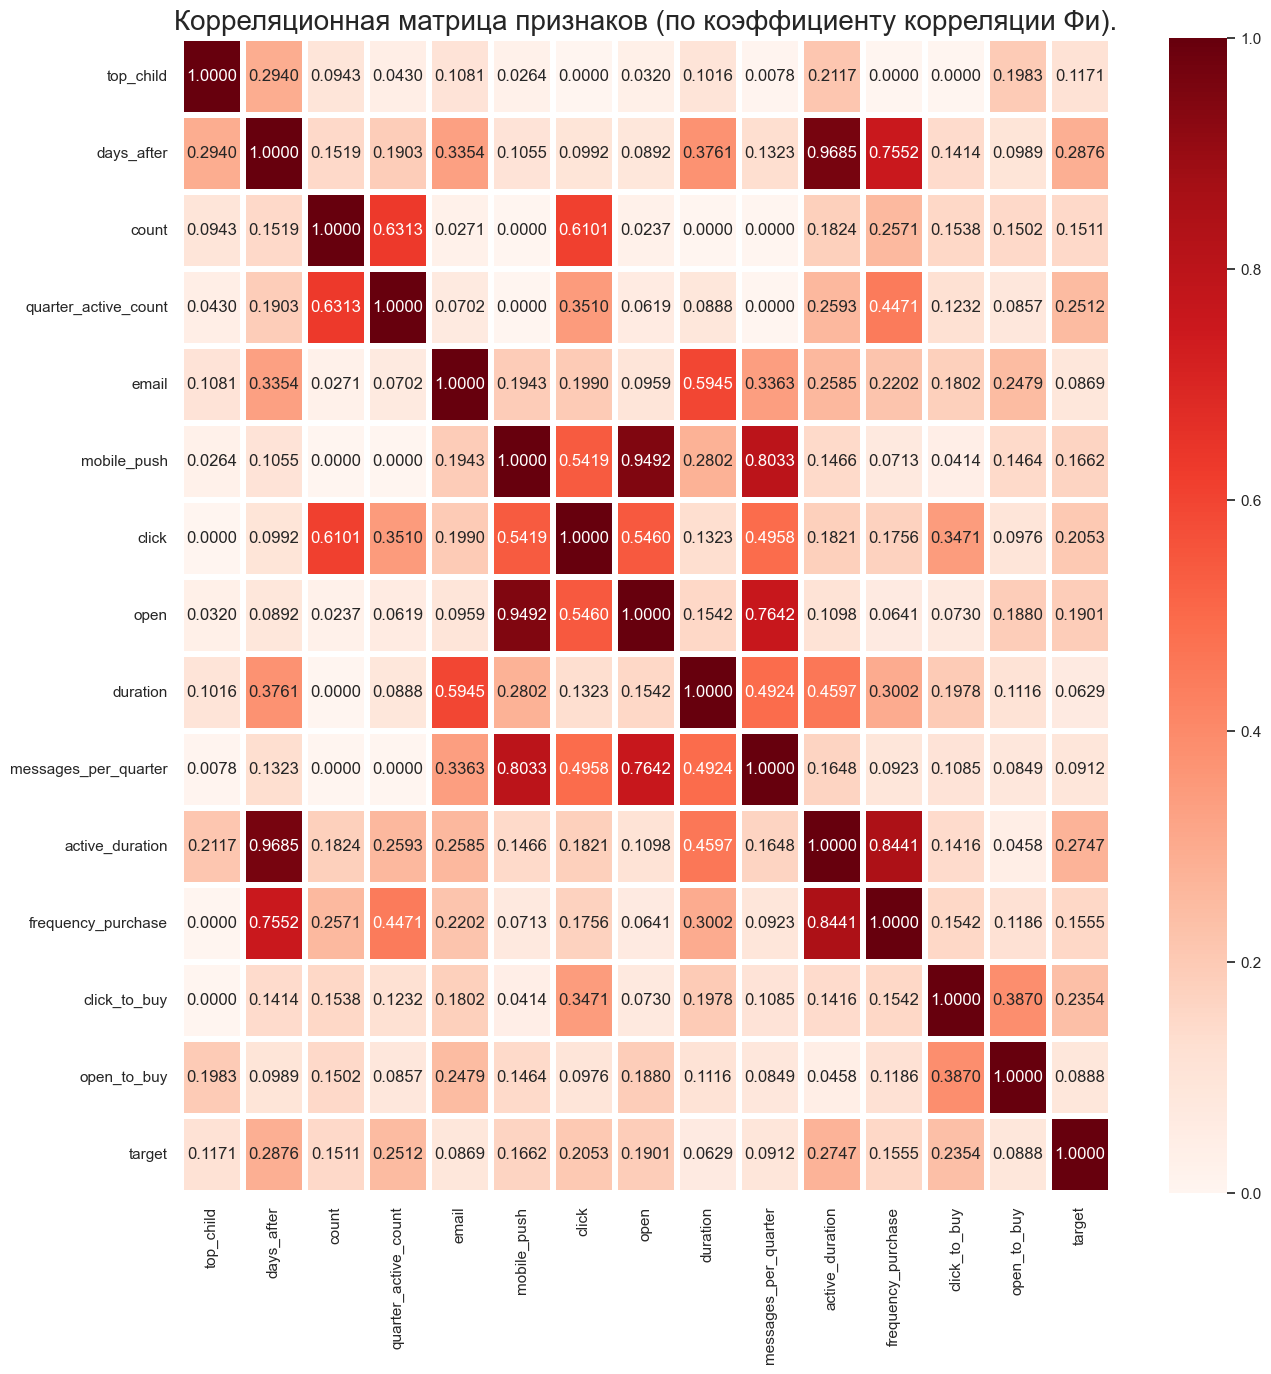

In [835]:
# строим матрицу корреляции
plt.figure(figsize=(15,15))
sns.heatmap(
    train_resampled.drop('client_id', axis=1).phik_matrix(
        interval_cols=interval_cols,
        verbose=False
    ),
    annot=True,
    cmap='Reds',
    fmt='.4f',
    linewidths=3
)
plt.title('Корреляционная матрица признаков (по коэффициенту корреляции Фи).', fontsize=20)
plt.show()

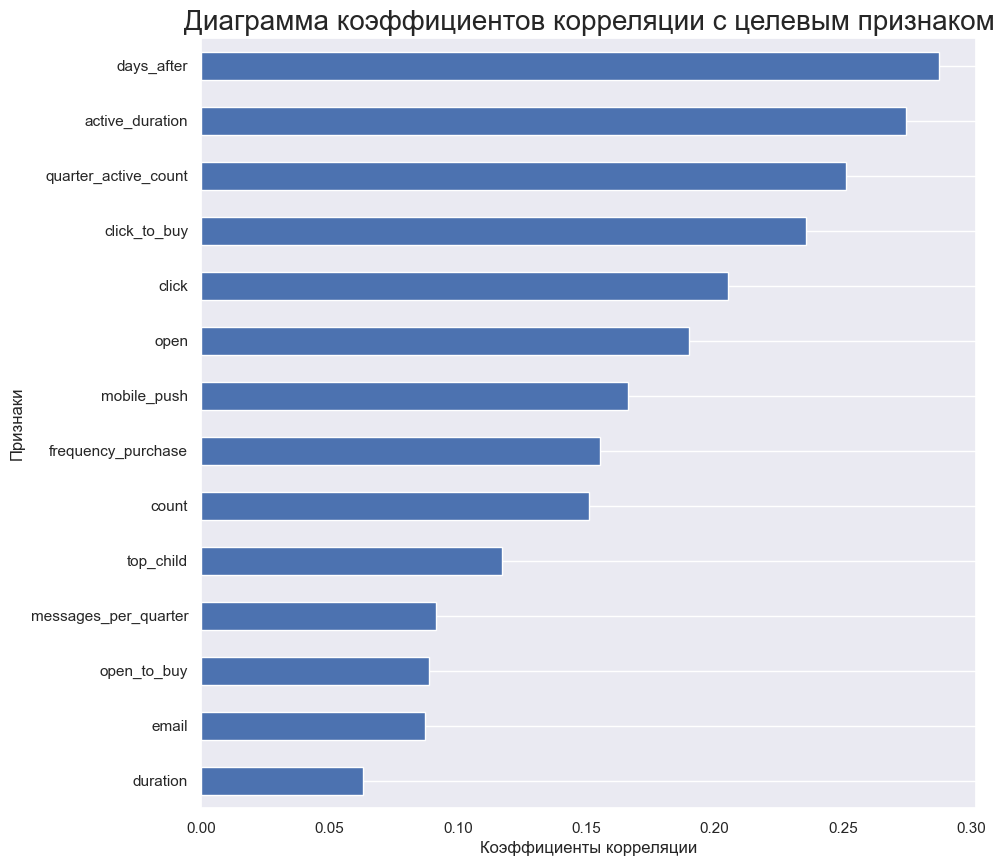

In [836]:
# построим диаграмму коэффициентов корреляции с целевым признаком
plt.figure(figsize=(10,10))
train_resampled.drop('client_id', axis=1).phik_matrix(
        interval_cols=interval_cols,
        verbose=False
)[TARGET].sort_values()[:-1].plot.barh()
plt.grid(axis='x')
plt.title('Диаграмма коэффициентов корреляции с целевым признаком', fontsize=20)
plt.xlabel('Коэффициенты корреляции')
plt.ylabel('Признаки')
plt.show()

In [837]:
#train_resampled = train_resampled.drop('cost', axis=1)
#X_test = X_test.drop('cost', axis=1)

In [839]:
#train_resampled = train_resampled.drop('top_parent', axis=1)
#X_test = X_test.drop('top_parent', axis=1)

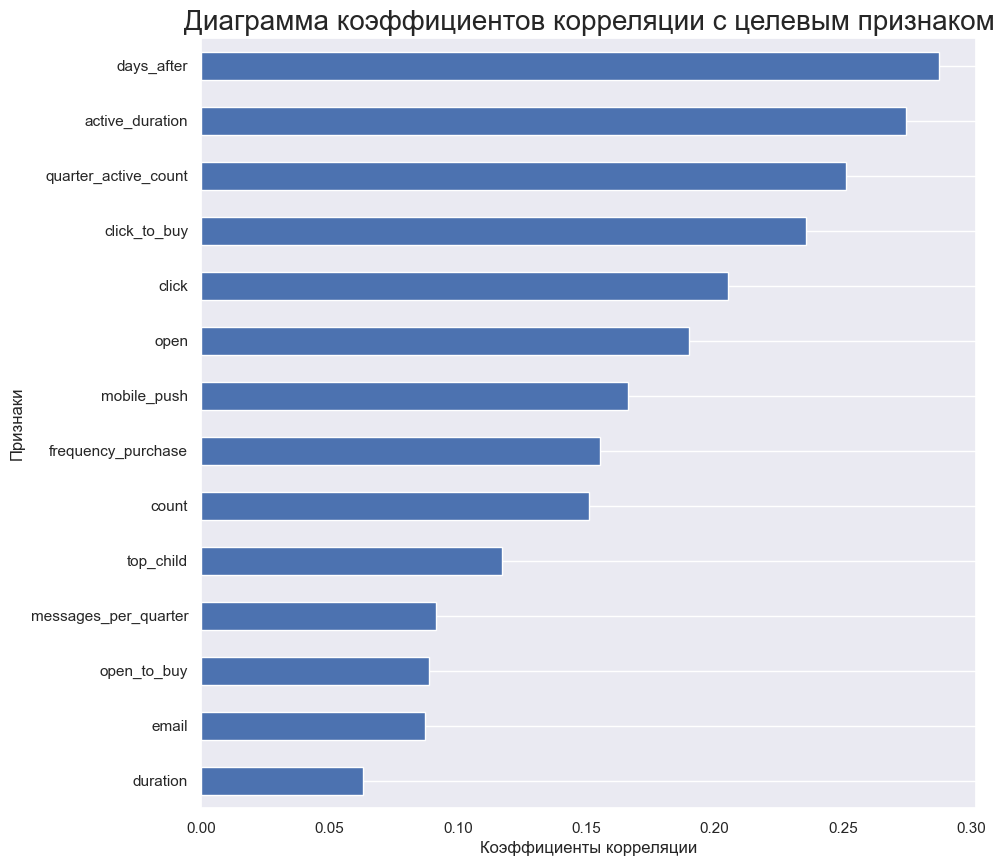

In [843]:
# построим диаграмму коэффициентов корреляции с целевым признаком
plt.figure(figsize=(10,10))
train_resampled.drop('client_id', axis=1).phik_matrix(
        interval_cols=interval_cols,
        verbose=False
)[TARGET].sort_values()[:-1].plot.barh()
plt.grid(axis='x')
plt.title('Диаграмма коэффициентов корреляции с целевым признаком', fontsize=20)
plt.xlabel('Коэффициенты корреляции')
plt.ylabel('Признаки')
plt.show()

# Обучение моделей

In [846]:
# создадим словарь для хранения метрик и времени обучения моделей
best_models = {'model':[], 'ROC-AUC_cv':[], 'ROC-AUC':[], 'Precision':[]}

## LGBM

In [849]:
# набор параметров модели
params_grid_lgb = {
    'num_iterations': [75, 150],
    'learning_rate': [.1],
    'max_depth': [5],
    'num_leaves': [31],
    'seed': [RANDOM_STATE],
    'metric': ['precision'],
    'boosting_type': ['gbdt'],
    'verbose': [-1]
}

In [851]:
# используем кросс-валидацию
grid_lgb = GridSearchCV(
    estimator = lgb.LGBMClassifier(),
    param_grid=params_grid_lgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [853]:
best_models['model'].append('LGBMClassifier')
grid_lgb.fit(
    train_resampled.drop(['target', 'client_id'], axis=1),
    train_resampled['target']
)
best_models['ROC-AUC_cv'].append(grid_lgb.best_score_)

In [854]:
# Оцениваем модель на тестовых данных
best_model_lgb = grid_lgb.best_estimator_
y_pred = best_model_lgb.predict(X_test.drop('client_id', axis=1))
y_pred_proba = best_model_lgb.predict_proba(X_test.drop('client_id', axis=1))[:, 1]
roc_auc_lgb = roc_auc_score(y_test, y_pred_proba)
precision_lgb = precision_score(y_test, y_pred)
best_models['ROC-AUC'].append(roc_auc_lgb)
best_models['Precision'].append(precision_lgb)

## CatBoostClassifier

In [856]:
# Параметры модели
params_grid_cb = {
    'iterations': [100],
    'learning_rate': [.1],
    'depth': [5],
    'verbose': [False],
    'eval_metric': ['AUC'],
    'random_seed': [RANDOM_STATE]
}

In [857]:
# используем кросс-валидацию, количество для модели LinearRegression
grid_cb = GridSearchCV(
    estimator=CatBoostClassifier(),
    param_grid=params_grid_cb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [858]:
best_models['model'].append('CatBoostClassifier')
grid_cb.fit(
    train_resampled.drop(['target', 'client_id'], axis=1),
    train_resampled['target']
)
best_models['ROC-AUC_cv'].append(grid_cb.best_score_)

In [859]:
# Оцениваем модель на тестовых данных
best_model_cb = grid_cb.best_estimator_
y_pred = best_model_cb.predict(X_test.drop('client_id', axis=1))
y_pred_proba = best_model_cb.predict_proba(X_test.drop('client_id', axis=1))[:, 1]
roc_auc_cb = roc_auc_score(y_test, y_pred_proba)
precision_cb = precision_score(y_test, y_pred)
best_models['ROC-AUC'].append(roc_auc_cb)
best_models['Precision'].append(precision_cb)

## Подготовка Pipeline

In [861]:
# подготовим печень количественных признаков
num_features = train_resampled.drop([TARGET, 'client_id'], axis=1).select_dtypes(include=['int', 'float']).columns.tolist()

In [862]:
# пайплайн для масштабирования количественных признаков, пропуски заполеям медианой
num_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [863]:
# пайплайн для кодирования и масштабирования всех признаков
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_features)
    ], 
    remainder='passthrough'
) 

In [864]:
# финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
)

## LogisiticRegression

In [870]:
from sklearn.linear_model import LogisticRegression
param_grid_lr = [    
    {
        'models': [
            LogisticRegression()
        ],
        'models__C': [0.1, 1, 10],
        'models__penalty': ['l2'],
        'models__solver': ['lbfgs', 'liblinear'],
        'models__class_weight': ['balanced']
    }
]

In [871]:
# используем кросс-валидацию, количество для модели LinearRegression
grid_lr = GridSearchCV(
    pipe_final,
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [872]:
best_models['model'].append('LinearRegression')
grid_lr.fit(
    train_resampled.drop([TARGET, 'client_id'], axis=1),
    train_resampled[TARGET]
)
best_models['ROC-AUC_cv'].append(grid_lr.best_score_)

In [873]:
# Оцениваем модель на тестовых данных
best_model_lr = grid_lr.best_estimator_
y_pred = best_model_lr.predict(X_test.drop('client_id', axis=1))
y_pred_proba = best_model_lr.predict_proba(X_test.drop('client_id', axis=1))[:, 1]

# dыводим метрики
roc_auc_lr = roc_auc_score(y_test, y_pred_proba)
precision_lr = precision_score(y_test, y_pred)
best_models['ROC-AUC'].append(roc_auc_lr)
best_models['Precision'].append(precision_lr)

## RandomForestClassifier

In [875]:
param_grid_rf = [
    {
        'models': [
            RandomForestClassifier(random_state=RANDOM_STATE)
        ],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [5, 8],
        'models__min_samples_split': [5, 10],
        'models__min_samples_leaf': [2, 4],
        'models__class_weight': ['balanced']
    }
]            

In [876]:
# используем кросс-валидацию, количество для модели LinearRegression
grid_rf = GridSearchCV(
    pipe_final,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [877]:
best_models['model'].append('RandomForestClassifier')
grid_rf.fit(
    train_resampled.drop([TARGET, 'client_id'], axis=1),
    train_resampled[TARGET]
)
best_models['ROC-AUC_cv'].append(grid_rf.best_score_)

In [886]:
# Оцениваем модель на тестовых данных
best_model_rf = grid_rf.best_estimator_
y_pred = best_model_rf.predict(X_test.drop('client_id', axis=1))
y_pred_proba = best_model_rf.predict_proba(X_test.drop('client_id', axis=1))[:, 1]
# метрики
roc_auc_rf = roc_auc_score(y_test, y_pred_proba)
precision_rf = precision_score(y_test, y_pred)
best_models['ROC-AUC'].append(roc_auc_rf)
best_models['Precision'].append(precision_rf)

# Анализ моделей

In [895]:
models_results = pd.DataFrame(best_models, columns=['model', 'ROC-AUC_cv', 'ROC-AUC', 'Precision'])

In [896]:
models_results

,model,ROC-AUC_cv,ROC-AUC,Precision
0,LGBMClassifier,0.8277,0.7225,0.3971
1,CatBoostClassifier,0.8047,0.7523,0.5208
2,LinearRegression,0.7408,0.7428,0.1941
3,RandomForestClassifier,0.7574,0.7325,0.2400
